# Imports

In [286]:
#!pip install -U scikit-learn

In [287]:
from Transformation import Transformation
import numpy as np
import math
from sklearn import preprocessing
from sklearn.neighbors import NearestNeighbors
import networkx as nx

# Input

In [288]:
transformation = Transformation()

# Create objects
stl_file_path = "3d_models/stl/Handle.stl"
mesh_data = transformation.stl_to_mesh(stl_file_path)
graph = transformation.mesh_to_graph(mesh_data)

transformation.print_graph_properties(graph, display_graph=False, display_labels=False)

Number of nodes: 5999
Number of edges: 17991


In [289]:
print(graph._node)

{(75.0252, -0.66553295, 3.8): {'index_triangle': {0, 6820, 164, 165, 6821, 6822}}, (75.01418, -0.49935842, 16.7): {'index_triangle': {0, 1, 165, 370, 371, 372}}, (75.0, 0.0, 3.8): {'index_triangle': {0, 1, 2, 6658, 6659, 11415, 11416, 11417, 6822, 6823, 6824, 6825, 6826, 6827, 6828, 6829, 6830, 6831, 6832, 6833, 6834, 6835, 6836, 6837, 6838, 6839, 6840, 6841, 6842, 6843, 6844, 6845, 6846, 6847, 6848, 6849, 6850, 6851, 6852, 6853, 6854, 6855, 6856, 6857, 6858, 6859, 6860, 6861, 6862, 6863, 6864, 6865, 6866, 6867, 6868, 6869, 6870, 6871, 6872, 6873, 6874, 6875, 6876, 6877, 6878, 6495}}, (75.00158, 0.16653232, 16.7): {'index_triangle': {1, 2, 3, 372, 373, 374}}, (75.0252, 0.66553295, 3.8): {'index_triangle': {2, 6659, 3, 4, 6660}}, (75.03937, 0.8314692, 16.7): {'index_triangle': {3, 4, 5, 374, 375, 376}}, (75.10067, 1.3272538, 3.8): {'index_triangle': {6660, 6661, 4, 5, 6, 6662}}, (75.12734, 1.4916434, 16.7): {'index_triangle': {5, 6, 7, 376, 377, 378}}, (75.22596, 1.9813722, 3.8): {'inde

# Point Sampler

### DevConv

In [290]:
def relu(array):
    return np.maximum(array, 0)

def sigmoid(array):
    return 1 / (1 + np.exp(-array))

In [291]:
class DevConv():
    def __init__(self, graph, output_dimension):
        self.graph = graph
        self.list_node = list(graph._node)

        self.W_phi = np.random.random((output_dimension))      #change
        self.W_theta = np.array([1, 2, 3])  # change
    
    def forward(self, previous_inclusion_score, return_flatten=True):
        list_inc_score = np.zeros((len(self.list_node), len(self.W_phi)))
        for index_current_node, (current_node, dict_neigh) in enumerate(self.graph._adj.items()):
            # print(index_current_node, " | ", current_node, " | ", dict_neigh)
            neigh_distances = np.zeros(shape=len(dict_neigh))
            for index_neigh, neigh_node in enumerate(dict_neigh.keys()):
                neigh_distances[index_neigh] = np.linalg.norm(np.multiply(self.W_theta, np.array(current_node) - np.array(neigh_node))) # norm(W_theta * (xi - xj))
            list_inc_score[index_current_node] = self.W_phi * np.max(neigh_distances)                                   # W_phi * max(distance)    

        # return if no previous inclusion score
        if len(previous_inclusion_score)==0:
            if return_flatten:
                list_inc_score = list_inc_score.flatten()
            return list_inc_score
        
        # mean the rows if more than one column
        if list_inc_score.shape[1]!=1:
            list_inc_score = np.mean(list_inc_score, axis=1)

        # array of array to array
        if len(list_inc_score.shape)==2:
            if list_inc_score.shape[1]==1:
                list_inc_score = list_inc_score.flatten()

        # Return the mean of previous and current inclusion score
        return np.mean(np.array([previous_inclusion_score, list_inc_score], dtype=np.float64), axis=0)
        

In [292]:
devconv = DevConv(graph, 1)
inclusion_score = devconv.forward(previous_inclusion_score=np.array([]))
inclusion_score = relu(inclusion_score)
print(inclusion_score)

devconv = DevConv(graph, 64)
inclusion_score = devconv.forward(previous_inclusion_score=inclusion_score)
inclusion_score = relu(inclusion_score)
print(inclusion_score)

devconv = DevConv(graph, 1)
inclusion_score = devconv.forward(previous_inclusion_score=inclusion_score)
inclusion_score = sigmoid(inclusion_score)
print(inclusion_score)
print(inclusion_score.shape)

[23.21604754 23.22202643 23.21610546 ...  7.29353192 20.92914533
  7.29476494]
[21.69094732 21.69653345 21.69100145 ...  6.81440786 19.55427547
  6.81555988]
[0.9999999  0.9999999  0.9999999  ... 0.99368031 0.9999995  0.99368568]
(5999,)


### Multinomial Sampling

In [293]:
normalized_inclusion_score = inclusion_score / np.sum(inclusion_score)  # normalize for multinomial sampling
normalized_inclusion_score = np.round(normalized_inclusion_score, 8)    # round to remove float imprecision

number_throws = 500     # small:more randomness    |   big:less randomness
mult_sampling = np.random.multinomial(number_throws, normalized_inclusion_score)
print(mult_sampling)

[0 0 0 ... 0 0 0]


In [294]:
target_number_point = min(len(graph._node), 50)   # number of points for the simplification

index_k_nodes = np.argpartition(mult_sampling, -target_number_point)[-target_number_point:]
list_k_nodes = np.array(list(graph._node.keys()))[index_k_nodes]
list_k_nodes = [tuple(e) for e in list_k_nodes]
print(list_k_nodes)

[(75.99106, 8.447791, -2.4572861), (75.0, -2.6241417, 3.3996358), (91.633286, 4.0099483, 42.5), (80.08181, 8.237194, 1.2106892), (75.0, -6.0434117, 1.3966535), (92.03719, -3.0965528, 42.5), (84.16007, 8.760632, 84.176285), (75.74507, -6.5098743, 1.0193683), (75.66222, 8.447791, -2.5005786), (78.31398, -6.9390492, 3.0955923), (91.30758, 4.590885, 42.5), (82.485054, 8.760632, 87.26128), (76.16378, -7.6759295, 85.54329), (84.578705, 8.760632, 82.206764), (83.466995, 8.793697, 42.5), (51.0, -7.593115, 85.55201), (75.20559, -7.328478, -0.12292136), (84.46553, -8.774797, 55.4), (87.08751, -2.9401166, 93.287506), (76.185814, 8.237194, -1.7788131), (86.395325, -8.114116, 85.57426), (78.402016, -7.328478, 1.8358475), (87.22794, -2.3044074, 93.42794), (78.66739, -7.328478, 82.60778), (90.23091, 5.7970243, 1.3876611), (87.40501, 0.99710757, -8.605006), (80.44656, -7.5075808, -8.433183), (90.93887, 5.145526, 16.7), (91.91503, -2.3044074, 84.7954), (78.18029, 8.672658, 90.98794), (90.6761, 0.333004

# KNN

In [295]:
XYZ = [list(e) for e in list_k_nodes]
print(XYZ)

[[75.99106, 8.447791, -2.4572861], [75.0, -2.6241417, 3.3996358], [91.633286, 4.0099483, 42.5], [80.08181, 8.237194, 1.2106892], [75.0, -6.0434117, 1.3966535], [92.03719, -3.0965528, 42.5], [84.16007, 8.760632, 84.176285], [75.74507, -6.5098743, 1.0193683], [75.66222, 8.447791, -2.5005786], [78.31398, -6.9390492, 3.0955923], [91.30758, 4.590885, 42.5], [82.485054, 8.760632, 87.26128], [76.16378, -7.6759295, 85.54329], [84.578705, 8.760632, 82.206764], [83.466995, 8.793697, 42.5], [51.0, -7.593115, 85.55201], [75.20559, -7.328478, -0.12292136], [84.46553, -8.774797, 55.4], [87.08751, -2.9401166, 93.287506], [76.185814, 8.237194, -1.7788131], [86.395325, -8.114116, 85.57426], [78.402016, -7.328478, 1.8358475], [87.22794, -2.3044074, 93.42794], [78.66739, -7.328478, 82.60778], [90.23091, 5.7970243, 1.3876611], [87.40501, 0.99710757, -8.605006], [80.44656, -7.5075808, -8.433183], [90.93887, 5.145526, 16.7], [91.91503, -2.3044074, 84.7954], [78.18029, 8.672658, 90.98794], [90.6761, 0.333004

In [296]:
def connect_extended_graph(XYZ, number_neigh=3):
    is_graph_connected = False
    while not is_graph_connected:
        # Create the nearest neighbors object
        _, indices = NearestNeighbors(n_neighbors=number_neigh).fit(XYZ).kneighbors(XYZ)
        # Create the graph from the nearest points
        extended_graph = nx.Graph()
        for index_poly, poly in enumerate(indices):
            for index_current_node in range(len(poly)):
                current_node = tuple(XYZ[poly[index_current_node]])
                for index_other_node in range(index_current_node+1, len(poly)):
                    edge = current_node, tuple(XYZ[poly[index_other_node]])
                    extended_graph.add_edge(*edge)
                    # if attribute do not exists
                    if len(extended_graph.nodes[current_node])==0:
                        extended_graph.nodes[current_node]['index_poly'] = set()
                    extended_graph.nodes[current_node]['index_poly'].add(index_poly)
        is_graph_connected = nx.is_connected(extended_graph)
        number_neigh += 1
    print("Number of neighbors : ", number_neigh-1)
    return extended_graph

In [297]:
extended_graph = connect_extended_graph(XYZ)

Number of neighbors :  7


Number of nodes: 50
Number of edges: 277


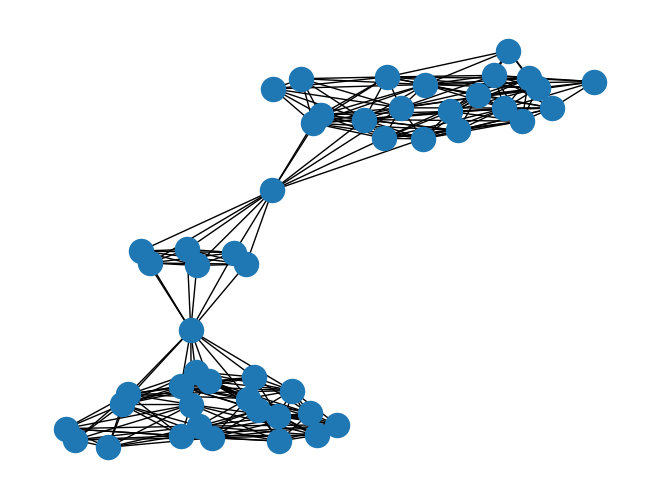

In [298]:
transformation.print_graph_properties(graph=extended_graph, display_graph=True, display_labels=False)

# Edge Predictor

In [299]:
devconv = DevConv(extended_graph, 64)
inclusion_score = devconv.forward(previous_inclusion_score=np.array([]), return_flatten=False)
print(inclusion_score.shape)

(50, 64)


In [300]:
"""
inclusion_score = [[f_1_1  , f_1_2  , ..., f_63_1  ],
                    ...,
                   [f_1_M-1, f_1_M-1, ..., f_63_M-1]]
M = number of points
64 = hidden dimensions
"""
from numpy import mean


f1i = np.mean(inclusion_score)
f1j = np.mean(inclusion_score)
wq = np.random.randint(100, size=(64,1))
wk = np.random.randint(100, size=(1,64))

f1i_wq = f1i*wq
f1j_wk = f1j*wk

wq_wk = int(np.matmul(f1j_wk, f1i_wq)) 

expo = np.exp(wq_wk)



C:\Users\Arthur\AppData\Local\Temp\ipykernel_6596\73126498.py:21: RuntimeWarning: overflow encountered in exp
  expo = np.exp(wq_wk)


### Sparse Attention

# Face Candidates

#### Inputs

In [301]:
adjacency = nx.adjacency_matrix(extended_graph)
S = np.random.rand(target_number_point, target_number_point)
print(adjacency)
print(S)

  (0, 1)	1
  (0, 2)	1
  (0, 3)	1
  (0, 4)	1
  (0, 5)	1
  (0, 6)	1
  (0, 7)	1
  (1, 0)	1
  (1, 2)	1
  (1, 3)	1
  (1, 4)	1
  (1, 5)	1
  (1, 6)	1
  (1, 7)	1
  (1, 8)	1
  (1, 9)	1
  (1, 11)	1
  (1, 48)	1
  (1, 49)	1
  (2, 0)	1
  (2, 1)	1
  (2, 3)	1
  (2, 4)	1
  (2, 5)	1
  (2, 6)	1
  :	:
  (47, 38)	1
  (47, 43)	1
  (47, 44)	1
  (47, 45)	1
  (47, 46)	1
  (47, 48)	1
  (48, 1)	1
  (48, 7)	1
  (48, 8)	1
  (48, 9)	1
  (48, 11)	1
  (48, 12)	1
  (48, 38)	1
  (48, 43)	1
  (48, 44)	1
  (48, 45)	1
  (48, 46)	1
  (48, 47)	1
  (48, 49)	1
  (49, 1)	1
  (49, 7)	1
  (49, 8)	1
  (49, 9)	1
  (49, 11)	1
  (49, 48)	1
[[0.23707843 0.18372835 0.34486031 ... 0.3205826  0.73877739 0.47467643]
 [0.90483864 0.44585584 0.40489651 ... 0.36893325 0.78478735 0.77941879]
 [0.31672639 0.37141935 0.91364766 ... 0.09817376 0.70361743 0.64157608]
 ...
 [0.22147522 0.33777965 0.32897512 ... 0.71127026 0.18651492 0.27230965]
 [0.60878477 0.91911582 0.88001429 ... 0.9374316  0.08679269 0.4163364 ]
 [0.1550463  0.05247318 0.962

In [302]:
A_s = np.zeros((target_number_point,target_number_point))

for i in range(target_number_point):
    for j in range(target_number_point):
        A_s[i,j] = np.matmul(np.matmul(S[i,:], adjacency.A), S[j,:][np.newaxis].T)

print(A_s)  # symmétrique
print(A_s.shape)

[[133.59225971 132.00876076 124.01400655 ... 147.76587637 149.54388274
  172.84694398]
 [132.00876076 128.39012462 124.48497046 ... 139.86858595 142.30278945
  169.55382499]
 [124.01400655 124.48497046 117.01292956 ... 137.50037435 135.35384544
  162.76955457]
 ...
 [147.76587637 139.86858595 137.50037435 ... 157.21485204 158.81540667
  187.62666835]
 [149.54388274 142.30278945 135.35384544 ... 158.81540667 159.93144052
  185.25789952]
 [172.84694398 169.55382499 162.76955457 ... 187.62666835 185.25789952
  224.38597873]]
(50, 50)


c:\Users\Arthur\miniconda3\envs\meshPFE\lib\site-packages\scipy\sparse\_base.py:719: VisibleDeprecationWarning: `.A` is deprecated and will be removed in v1.13.0. Use `.toarray()` instead.
  warn(np.VisibleDeprecationWarning(


# Face Classifier

### TriConv

#### Inputs

In [303]:
triangles = list(nx.simple_cycles(extended_graph, length_bound=3))  # [triangle0, triangle1,...] | triangle0 = [node1,node2,node3] | node1 = (x ,y ,z)
print(triangles)
print(np.array(triangles).shape)    #nb_triangle, 3 nodes, 3 dimensions par node

[[(39.0, -3.0965528, -13.237194), (75.66222, 8.447791, -2.5005786), (75.86647, -4.1574683, -12.733306)], [(39.0, -3.0965528, -13.237194), (75.66222, 8.447791, -2.5005786), (75.20559, -7.328478, -0.12292136)], [(39.0, -3.0965528, -13.237194), (75.66222, 8.447791, -2.5005786), (75.0, -6.0434117, 1.3966535)], [(39.0, -3.0965528, -13.237194), (75.66222, 8.447791, -2.5005786), (75.74507, -6.5098743, 1.0193683)], [(39.0, -3.0965528, -13.237194), (75.66222, 8.447791, -2.5005786), (75.0, -2.6241417, 3.3996358)], [(39.0, -3.0965528, -13.237194), (75.0, -2.6241417, 3.3996358), (75.0, -6.0434117, 1.3966535)], [(39.0, -3.0965528, -13.237194), (75.0, -2.6241417, 3.3996358), (75.74507, -6.5098743, 1.0193683)], [(39.0, -3.0965528, -13.237194), (75.0, -2.6241417, 3.3996358), (75.20559, -7.328478, -0.12292136)], [(39.0, -3.0965528, -13.237194), (75.0, -2.6241417, 3.3996358), (75.86647, -4.1574683, -12.733306)], [(39.0, -3.0965528, -13.237194), (75.0, -6.0434117, 1.3966535), (75.74507, -6.5098743, 1.019

#### Calculate barycenter

In [304]:
barycenters = list()

for _, triangle in enumerate(triangles):
    b_x = (triangle[0][0] + triangle[1][0] + triangle[2][0]) / 3
    b_y = (triangle[0][1] + triangle[1][1] + triangle[2][1]) / 3
    b_z = (triangle[0][2] + triangle[1][2] + triangle[2][2]) / 3
    barycenters.append([b_x, b_y, b_z])

print(barycenters)
print(len(barycenters))

[[63.509562174479164, 0.3979233105977376, -9.490359624226889], [63.289265950520836, -0.6590798695882162, -5.286897977193196], [63.22073872884115, -0.23072449366251627, -4.780373255411784], [63.469095865885414, -0.3862120310465495, -4.906134923299153], [63.22073872884115, 0.9090321858723959, -4.112712224324544], [63.0, -3.9213689168294272, -2.8136351903279624], [63.24835713704427, -4.076856295267741, -2.939396858215332], [63.06853230794271, -4.349724133809407, -3.320159912109375], [63.28882344563802, -3.2927207946777344, -7.523621877034505], [63.24835713704427, -5.216613133748372, -3.607057571411133], [63.06853230794271, -5.489480972290039, -3.987820625305176], [63.28882344563802, -4.432477951049805, -8.191282272338867], [63.31688435872396, -5.644968668619792, -4.113582293192546], [63.53718058268229, -4.58796501159668, -8.317043940226236], [63.35735066731771, -4.860832850138347, -8.697807312011719], [75.9463602701823, 8.377592086791992, -2.2455593744913735], [77.24502563476562, 8.377592

In [305]:
def connect_triangle_graph(XYZ, number_neigh=20):
    # Create the nearest neighbors object
    _, indices = NearestNeighbors(n_neighbors=number_neigh).fit(XYZ).kneighbors(XYZ)
    # Create the graph from the nearest points
    extended_graph = nx.Graph()
    for index_poly, poly in enumerate(indices):
        for index_current_node in range(len(poly)):
            current_node = tuple(XYZ[poly[index_current_node]])
            for index_other_node in range(index_current_node+1, len(poly)):
                edge = current_node, tuple(XYZ[poly[index_other_node]])
                extended_graph.add_edge(*edge)
                # if attribute do not exists
                if len(extended_graph.nodes[current_node])==0:
                    extended_graph.nodes[current_node]['index_poly'] = set()
                extended_graph.nodes[current_node]['index_poly'].add(index_poly)
    return extended_graph

In [306]:
graph_triangles = connect_triangle_graph(barycenters)

Number of nodes: 654
Number of edges: 15819


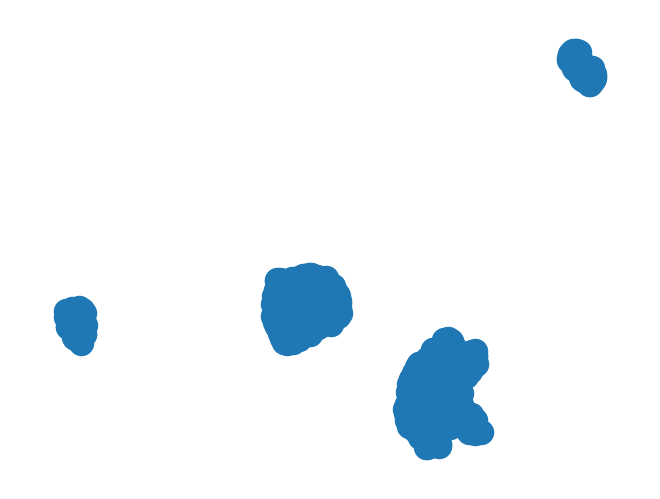

In [307]:
transformation.print_graph_properties(graph=graph_triangles, display_graph=True, display_labels=False)

#### calculate e norm matrix

In [308]:
diff_vectors = list()

for _, triangle in enumerate(triangles):
    e_ij = np.linalg.norm(np.array(triangle[0]) - np.array(triangle[1]))
    e_ik = np.linalg.norm(np.array(triangle[0]) - np.array(triangle[2]))
    e_jk = np.linalg.norm(np.array(triangle[1]) - np.array(triangle[2]))
    diff_vectors.append([e_ij, e_ik, e_jk])
print(diff_vectors)
print(len(diff_vectors))

[[39.908203, 36.885174, 16.237087], [39.908203, 38.73936, 15.960966], [39.908203, 38.972214, 15.020717], [39.908203, 39.56135, 15.366478], [39.908203, 39.661156, 12.563389], [39.661156, 38.972214, 3.9627445], [39.661156, 39.56135, 4.6173286], [39.661156, 38.73936, 5.8806], [39.661156, 36.885174, 16.228792], [38.972214, 39.56135, 0.9565892], [38.972214, 38.73936, 2.0006921], [38.972214, 36.885174, 14.281572], [39.56135, 38.73936, 1.5053167], [39.56135, 36.885174, 13.952943], [38.73936, 36.885174, 13.01975], [0.33167967, 0.7366182, 0.9162157], [0.33167967, 5.4984217, 5.775004], [0.33167967, 6.2053785, 6.3737965], [0.33167967, 7.270856, 7.3234534], [0.33167967, 8.325324, 8.329853], [0.33167967, 12.564769, 12.563389], [0.7366182, 5.4984217, 4.910795], [0.7366182, 6.2053785, 5.4748607], [0.7366182, 7.270856, 6.588655], [0.7366182, 8.325324, 7.728444], [0.7366182, 12.564769, 12.090951], [5.4984217, 6.2053785, 2.8919306], [5.4984217, 7.270856, 5.9372525], [5.4984217, 8.325324, 7.787607], [5.4

#### Calculate r

In [309]:
r_matrix = np.zeros((len(triangles),len(triangles), 5))

for n, triangle_n in enumerate(triangles):
    for m, triangle_m in enumerate(triangles):
        t_min = min(diff_vectors[n]) - min(diff_vectors[m])
        t_max = max(diff_vectors[n]) - max(diff_vectors[m])
        diff_bary = np.array(barycenters[n]) - np.array(barycenters[m])
        r_matrix[n, m] = [t_min, t_max, diff_bary[0], diff_bary[1], diff_bary[2]]

print(r_matrix)
print(r_matrix.shape)   # nb_triangles, nb_triangles, 5dim/triangles

[[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00]
  [ 2.76121140e-01  0.00000000e+00  2.20296224e-01  1.05700318e+00
   -4.20346165e+00]
  [ 1.21637058e+00  0.00000000e+00  2.88823446e-01  6.28647804e-01
   -4.70998637e+00]
  ...
  [ 1.42235670e+01  2.38233318e+01 -1.81587423e+01 -3.77266169e+00
   -9.23246797e+01]
  [ 1.06734638e+01  2.98681698e+01 -1.63929850e+01  7.65849384e+00
   -9.35763480e+01]
  [ 1.42235670e+01  3.25310669e+01 -2.29517619e+01 -7.20239814e+00
   -9.28440278e+01]]

 [[-2.76121140e-01  0.00000000e+00 -2.20296224e-01 -1.05700318e+00
    4.20346165e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00]
  [ 9.40249443e-01  0.00000000e+00  6.85272217e-02 -4.28355376e-01
   -5.06524722e-01]
  ...
  [ 1.39474459e+01  2.38233318e+01 -1.83790385e+01 -4.82966487e+00
   -8.81212180e+01]
  [ 1.03973427e+01  2.98681698e+01 -1.66132812e+01  6.60149066e+00
   -8.93728863e+01]
  [ 1.39474459e+01  3.2531066

#### Calculate f

# Simplified Mesh